In [1]:
import os                        # Provides functions for interacting with the operating system                
import numpy as np               # general-purpose array-processing package.
import tensorflow as tf          # library for fast numerical computing created
import pickle                    # used for serializing and de-serializing a Python object structure.
import random                    # Random to randomise the train and validation set
import pandas as pd              # for data manipulation and analysis
import matplotlib.pyplot as plt  # for visualization
import zipfile                   # to work with zip files
import collections               # containers that are used to store collections of data

<i>Extract all the files in current directory. Converted into zip because I trained model on Google Colab</i>

In [67]:
with zipfile.ZipFile("Vision_task_dataset_public-20190409T195138Z-001.zip") as f:
    f.extractall("./")
base_dir = "Vision_task_dataset_public"
os.listdir("./Vision_task_dataset_public")

['test_image.pkl',
 'train_label.pkl',
 'hitkul(sample_submission).csv',
 'train_image.pkl']

<i>Read the datasets from the pickle files</i>

In [0]:
train_images = pickle.load(open(os.path.join(base_dir, "train_image.pkl"), "rb"))
test_images = pickle.load(open(os.path.join(base_dir, "test_image.pkl"), "rb"))
train_labels = pickle.load(open(os.path.join(base_dir, "train_label.pkl"), "rb"))
submission_df = pd.read_csv(os.path.join(base_dir, "hitkul(sample_submission).csv"))

<i>Check the length of test and train dataset and length of a row in train dataset.<br>
Getting the format of submission file</i>

In [69]:
print(len(train_images), len(train_labels), len(test_images), len(train_images[0]), train_labels[0], len(test_images[0]))
print(collections.Counter(train_labels).most_common())
submission_df.head()

8000 8000 2000 784 0 784
[(0, 2000), (2, 2000), (3, 2000), (6, 2000)]


,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


<i>To do oneHotEncoding we need the classes in sequence order so I replaced class 6 with class 1,and did oneHotEncoding<i/>

In [0]:
num_classes = 4
train_labels = np.array([1 if i==6 else i for i in train_labels])
labels = np.zeros((len(train_labels), num_classes), dtype=np.int32)
labels[np.arange(len(train_labels)), train_labels] = 1

<i>Converted the image in vector form to 2-D matrix of size 28 x 28, and displaying a random image</i>

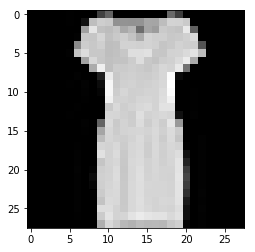

In [71]:
train_images = np.reshape(train_images, [-1, 28, 28])
plt.imshow(train_images[4001], cmap='gray', vmin=0, vmax=255)
plt.show()

<i>To perform Convolutional operation we need images in 3-D form so I converted the images in size of 28 x 28 x 1</i>

In [0]:
train_images = np.reshape(train_images, [-1, 28, 28, 1])
test_images = np.reshape(test_images, [-1, 28, 28, 1])

<i>Batch Generator function generates batches of images and labels and shuffles the data if specified </i>

In [73]:
def batch_generator(images, batch_size, labels=None, shuffle=True):
    if shuffle:                                                        #shuffling the data base
        shuff_ind = np.random.permutation(len(images))                 #np.random.permutation is useful when you need to 
                                                                       #shuffle ordered pairs, especially for classification:                
        images = images[shuff_ind]
        if labels is not None:
            labels = labels[shuff_ind]
    for i in range(len(images)//batch_size):
        imgs = images[i*batch_size: i*batch_size+batch_size]
        if labels is not None:
            lbls = labels[i*batch_size: (i+1)*batch_size]
            yield imgs, lbls
        else:
            yield imgs
    return

gen = batch_generator(train_images, 128, labels)
imgs, lbls = next(gen)
imgs.shape, lbls.shape

((128, 28, 28, 1), (128, 4))

<i>Conv2d function creates a layer of Convolution operation by initialising the filters and bias, performs the convolution operation and returns the output through activation function "relu" <br>
fc function creates a fully connected layer in computational graph </i>

In [0]:
def conv2d(x, out_channels, ksize, stride, padding):
    in_shape = x.get_shape().as_list()
    in_channels = in_shape[-1]
    w = tf.get_variable(name="w", shape=[ksize, ksize, in_channels, out_channels], dtype=tf.float32, 
                            initializer=tf.truncated_normal_initializer(mean=0., stddev=np.sqrt(1/(in_shape[1]*in_shape[2]))))
    b = tf.get_variable(name="b", shape=[out_channels], dtype=tf.float32, 
                        initializer=tf.random_uniform_initializer(minval=0., maxval=0.1))
    return tf.nn.relu(tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding=padding) + b)

def fc(x, out, activation):
    in_shape = x.get_shape().as_list()
    w = tf.get_variable(name="w", shape=[in_shape[-1], out], dtype=tf.float32, 
                       initializer=tf.truncated_normal_initializer(mean=0., stddev=np.sqrt(1/in_shape[-1])))
    b = tf.get_variable(name="b", shape=[out], dtype=tf.float32, 
                       initializer=tf.random_uniform_initializer(minval=0., maxval=0.1))
    return activation(tf.matmul(x, w) + b)

<i>Now we define the computation graph having layers:<br>
1-Convolution(28 x 28 x 64)<br>
2-Max Pool(14 x 14 x 64)<br>
3-Convolution(14 x 14 x 128)<br>
4-Convolution(14 x 14 x 128)<br>
5-MaxPool(7 x 7 x 128)<br>
6-Convolution(7 x 7 x 256)<br>
7-Flatten(7 * 7 * 256)<br>
8-Fully connected Layer(4)</i>

In [0]:
tf.reset_default_graph()
inp_plh = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name="input_placeholder")
lbl_plh = tf.placeholder(dtype=tf.int32, shape=[None, num_classes], name="label_placeholder")
with tf.variable_scope("layer1"):
    conv = conv2d(inp_plh, 64, 3, 1, "SAME")
mp = tf.nn.max_pool(conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")
with tf.variable_scope("layer2"):
    conv = conv2d(mp, 128, 3, 1, "SAME")
with tf.variable_scope("layer3"):
    conv = conv2d(conv, 128, 3, 1, "SAME")
mp = tf.nn.max_pool(conv, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="SAME")
with tf.variable_scope("layer4"):
    conv = conv2d(mp, 256, 3, 1, "SAME")
flattened = tf.reshape(conv, [-1, 7*7*256])
with tf.variable_scope("layer5"):
    logits = fc(flattened, num_classes, lambda x: x)
pred_prob = tf.nn.softmax(logits)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=lbl_plh))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred_prob, axis=1), tf.argmax(lbl_plh, axis=1)), dtype=tf.float32))
optimizer = tf.train.AdamOptimizer().minimize(loss)

<i>Below codes are used to train the data and calculating average accuracy and loss after each epoch. <br>
then we predict on the test data.</i>

In [76]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(50):
        acc_list = []
        loss_list = []
        gen = batch_generator(train_images, 256, labels)
        for imgs, lbls in gen:
            _, loss_val, acc_val = sess.run([optimizer, loss, accuracy], feed_dict={inp_plh: imgs, lbl_plh: lbls})
            acc_list.append(acc_val)
            loss_list.append(loss_val)
        print("Epoch %d completed"%(epoch+1))
        print("Average Loss: ", np.mean(loss_list))
        print("Average Accuracy: ", np.mean(acc_list))
    print("Predicting")
    test_labels = []
    gen = batch_generator(test_images, 100, shuffle=False)
    for imgs in gen:
        pred_val = sess.run(pred_prob, feed_dict={inp_plh: imgs})
        pred_val = np.argmax(pred_val, axis=1)
        test_labels.extend(pred_val)

Epoch 1 completed
Average Loss:  42.09049
Average Accuracy:  0.5302419
Epoch 2 completed
Average Loss:  0.8670434
Average Accuracy:  0.7581905
Epoch 3 completed
Average Loss:  0.5020708
Average Accuracy:  0.81602824
Epoch 4 completed
Average Loss:  0.41239586
Average Accuracy:  0.8453881
Epoch 5 completed
Average Loss:  0.34510937
Average Accuracy:  0.8671875
Epoch 6 completed
Average Loss:  0.2988869
Average Accuracy:  0.88671875
Epoch 7 completed
Average Loss:  0.271472
Average Accuracy:  0.8985635
Epoch 8 completed
Average Loss:  0.2442009
Average Accuracy:  0.9073841
Epoch 9 completed
Average Loss:  0.20878759
Average Accuracy:  0.92552924
Epoch 10 completed
Average Loss:  0.18208215
Average Accuracy:  0.93472785
Epoch 11 completed
Average Loss:  0.15186056
Average Accuracy:  0.94821066
Epoch 12 completed
Average Loss:  0.12761654
Average Accuracy:  0.9610635
Epoch 13 completed
Average Loss:  0.1112223
Average Accuracy:  0.96522176
Epoch 14 completed
Average Loss:  0.0894066
Averag

<i>During oneHotEncoding we have replaced 6 with 1 so here we are replacing 1 with 6 and generating submisson.csv file after predicting on the test set.</i>

In [79]:
test_labels = [6 if i==1 else i for i in test_labels]
submission = pd.DataFrame()
submission["image_index"] = list(range(len(test_images)))
submission["class"] = test_labels
submission.to_csv("submission.csv", index=False)
submission.head(50)

,image_index,class
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0
